In [2]:
import sys
import tensorflow as tf
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

2024-09-18 11:43:31.674972: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 11:43:31.675168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 11:43:31.891183: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-18 11:43:32.580019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-18 11:43:38.803412: W tensorflow/compiler/tf2

# Convolutional Layers

In [3]:
from sklearn.datasets import load_sample_images

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images) # this line is cutting the center of the image (70 x 120)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images) # rescaling the pixes to a number between 0 and 1

2024-09-18 11:44:00.194924: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-09-18 11:44:00.195059: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: renan-Latitude-3450
2024-09-18 11:44:00.195102: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: renan-Latitude-3450
2024-09-18 11:44:00.195469: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.183.1
2024-09-18 11:44:00.195609: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.183.1
2024-09-18 11:44:00.195660: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.183.1


In [4]:
images.shape  # (batch, height, width, color chanels)

TensorShape([2, 70, 120, 3])

In [5]:
tf.random.set_seed(42)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [6]:
fmaps.shape

TensorShape([2, 64, 114, 32])

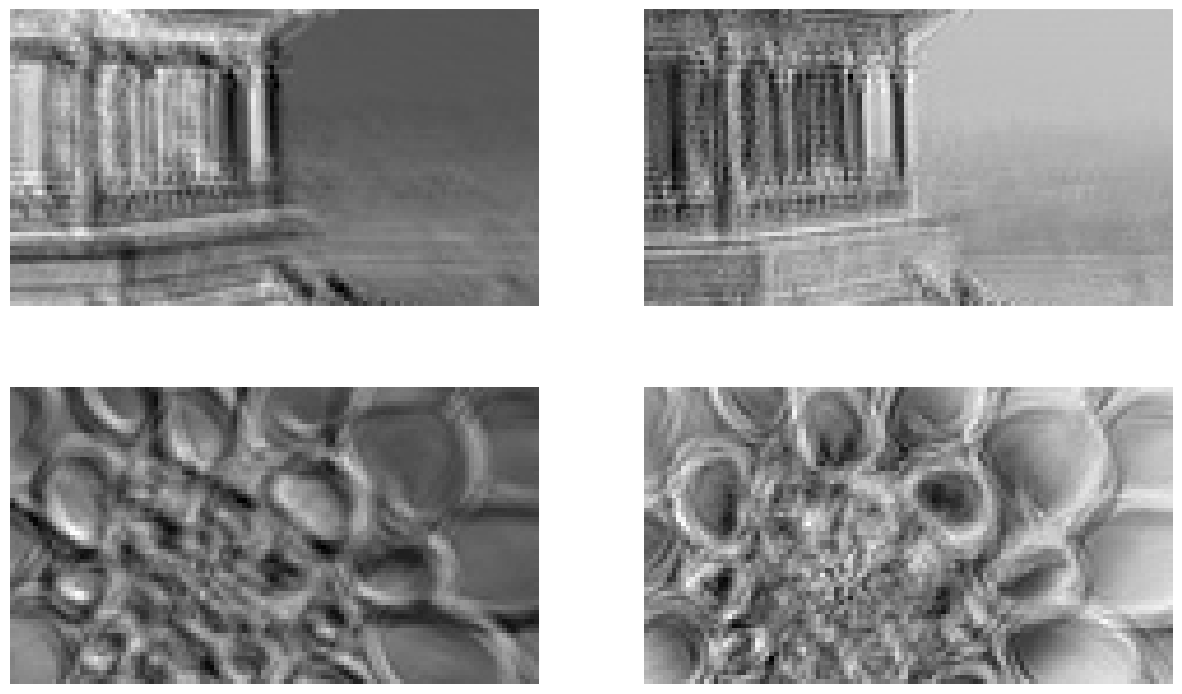

In [7]:
# displays the output

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

In [8]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                  padding="same")
fmaps = conv_layer(images)

In [9]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [10]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                   padding="same", strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

# Pooling Layers

### Implementing Pooling Layers with Keras

In [11]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [12]:
output = max_pool(images)

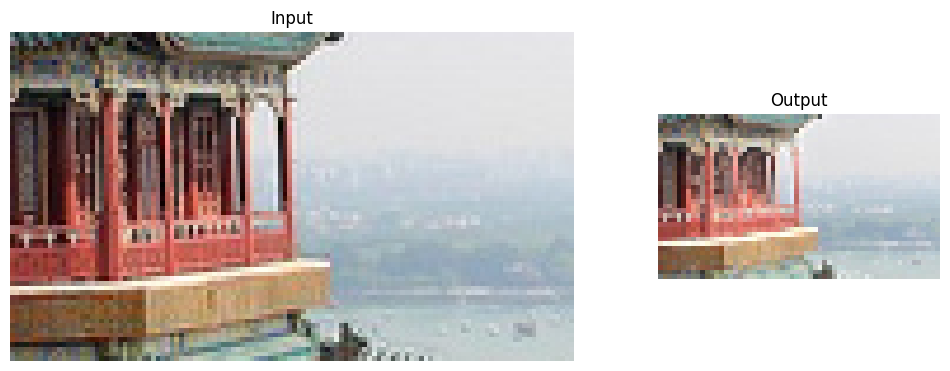

In [13]:
# this cells shows what max pooling with stride=2 looks like

import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()


In [14]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [15]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

In [16]:
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338624, 0.5971759 , 0.5824972 ],
       [0.76306933, 0.2601113 , 0.10849128]], dtype=float32)>

# CNN Architectures

In [17]:
import numpy as np

In [18]:
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [19]:
from functools import partial

tf.random.set_seed(42)

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                       activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                         kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                         kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

In [20]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
             metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=1,  # the epochs is = 1 because take to long to run 10 epochs 
                   validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretending we got new images
y_pred = model.predict(X_new)

1/1 [==============================] - 0s 134ms/step


### Implementing a ResNet-34 CNN Using Keras

In [21]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                       padding="same", kernel_initializer="he_normal", use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [22]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))

# Using Pretrained Models from Keras

In [23]:
model = tf.keras.applications.ResNet50(weights="imagenet")

In [24]:
images = load_sample_images()["images"]
images_resized = tf.keras.layers.Resizing(height=224, width=224,
                                         crop_to_aspect_ratio=True)(images)

In [25]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

In [26]:
y_proba = model.predict(inputs)
y_proba.shape

1/1 [==============================] - 1s 1s/step


(2, 1000)

In [27]:
top_K = tf.keras.applications.resnet50.decode_predictions(y_proba, top=3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f" {class_id} - {name:12s} {y_proba:.2%}")

Image #0
 n03877845 - palace       54.69%
 n03781244 - monastery    24.71%
 n02825657 - bell_cote    18.55%
Image #1
 n04522168 - vase         32.67%
 n11939491 - daisy        17.82%
 n03530642 - honeycomb    12.04%


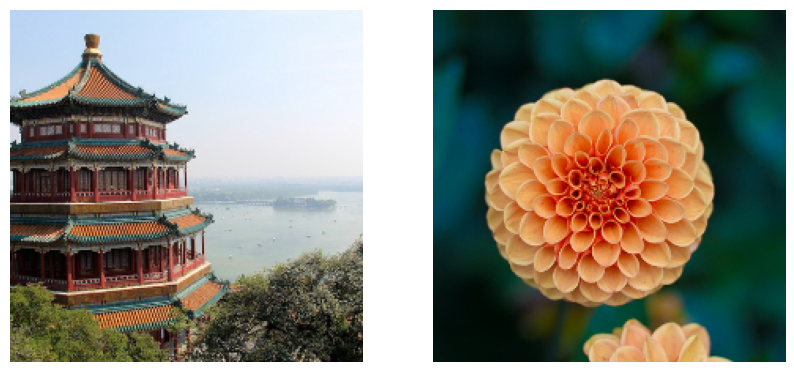

In [28]:
plt.figure(figsize=(10, 6))
for idx in (0, 1):
    plt.subplot(1, 2, idx + 1)
    plt.imshow(images_resized[idx] / 255)
    plt.axis("off")

plt.show()

# Pretrained Models for Transfer Learning

In [29]:
# pip install tensorflow_datasets (this line is coment because I don't need to install more than once)

In [46]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

In [31]:
dataset_size

3670

In [32]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [33]:
n_classes

5

In [34]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True
)

2024-09-18 11:52:02.445419: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


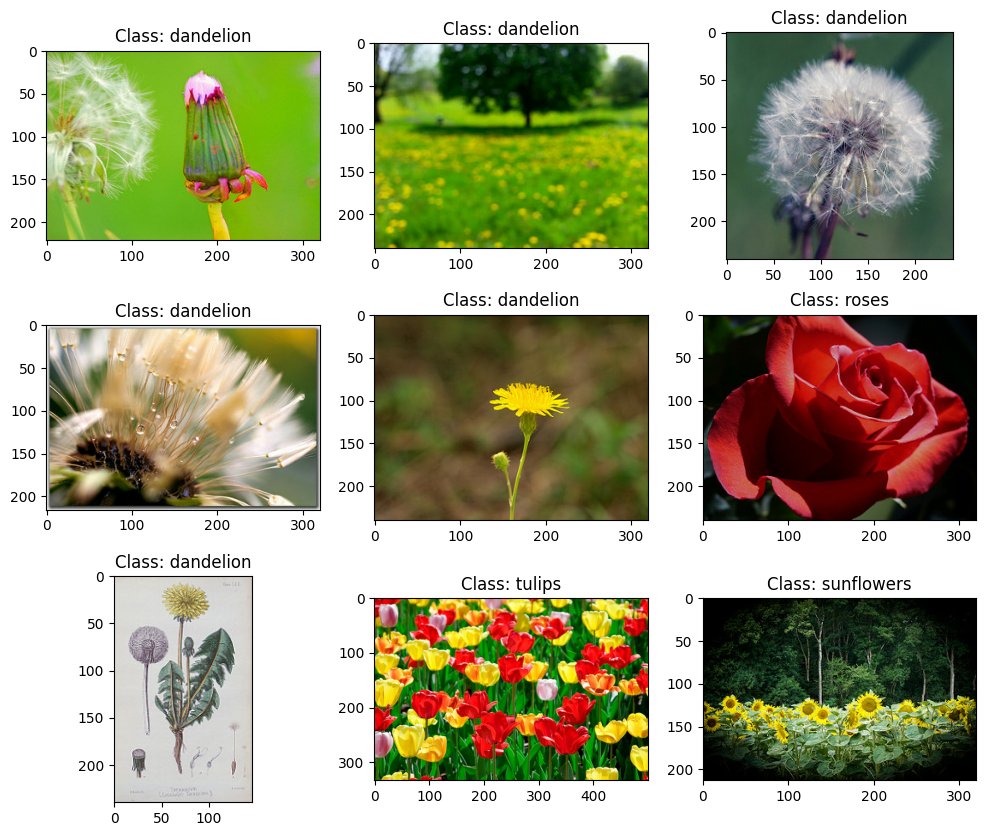

In [35]:
# display the first 9 images in the validation set

plt.figure(figsize=(12, 10))
index=0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")

plt.show()

In [36]:
tf.keras.backend.clear_session()

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

2024-09-18 11:52:04.219935: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


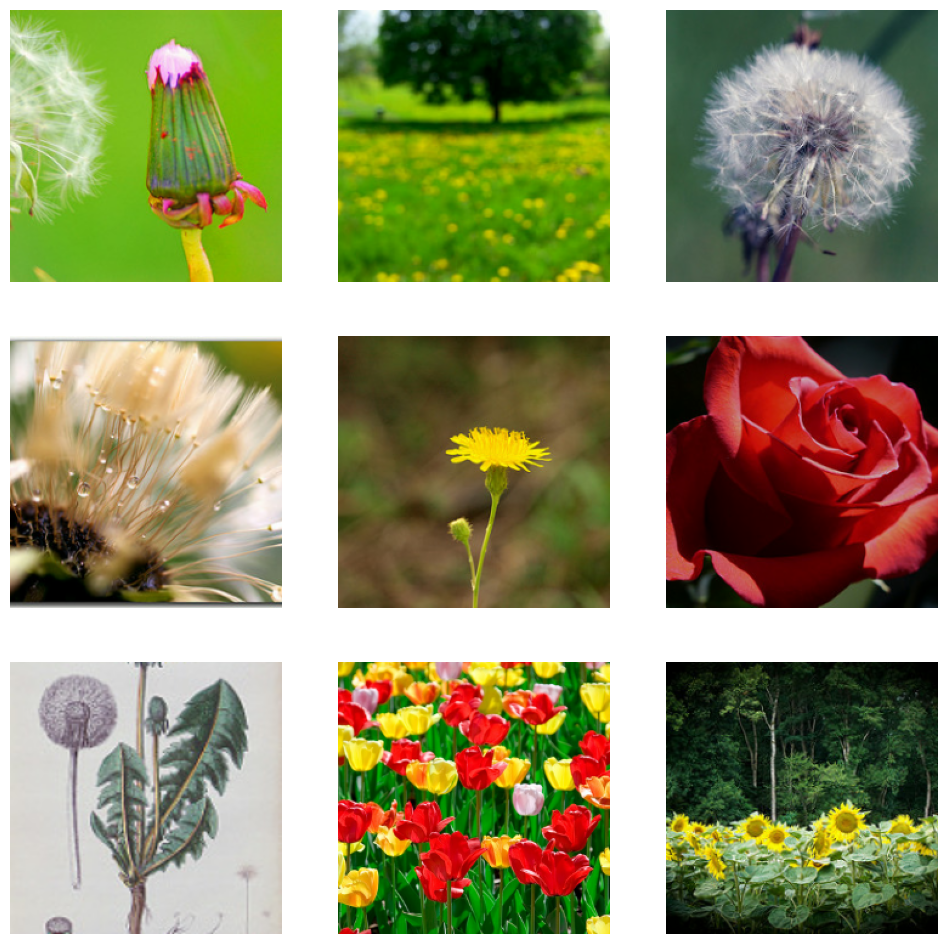

In [37]:
# first 9 images in the valid set

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt. subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)
        plt.axis("off")

plt.show()

In [38]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

2024-09-18 11:52:05.192389: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


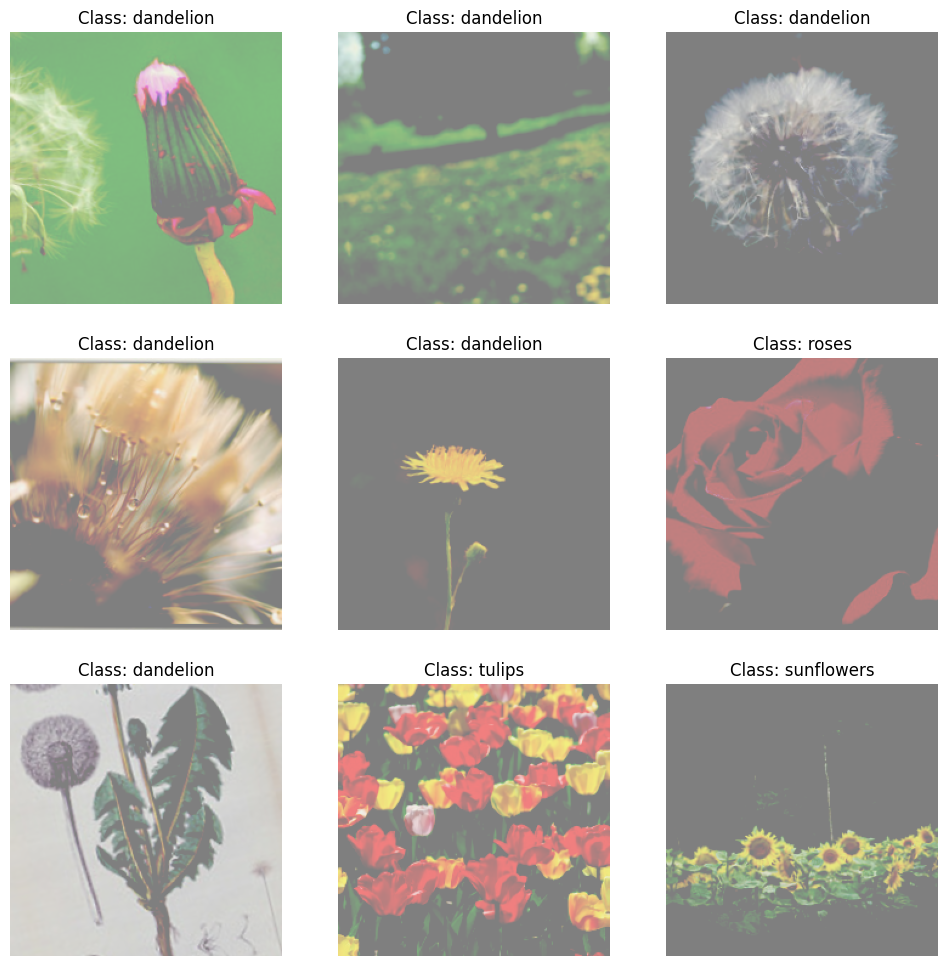

In [39]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [40]:
tf.random.set_seed(42)
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [41]:
# freezing layers
for layer in base_model.layers:
    layer.trainable = False

In [43]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 [==============================] - 485s 6s/step - loss: 0.2473 - accuracy: 0.9313 - val_loss: 0.6922 - val_accuracy: 0.8530
Epoch 2/3
86/86 [==============================] - 566s 7s/step - loss: 0.1333 - accuracy: 0.9553 - val_loss: 0.5377 - val_accuracy: 0.8675
Epoch 3/3
86/86 [==============================] - 700s 8s/step - loss: 0.0922 - accuracy: 0.9673 - val_loss: 0.5758 - val_accuracy: 0.8657


In [ ]:
# unfreeze the layers (I stopped it, because my pc can't handle it)

for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

# Classification and Localization

In [48]:
tf.random.set_seed(42)
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                    include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(inputs=base_model.input,
                      outputs=[class_output, loc_output])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
             loss_weights=[0.8, 0.2],
             optimizer=optimizer, metrics=["accuracy"])

In [ ]:
def add_random_bounding_boxes(images, labels):
    fake_boxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_boxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, epochs=2)

Epoch 1/2
